# **Convolutional Neural Network**
**Starting parameters**:

- Number of epochs: 100
- Learning rate: 0.0005
- Layers: [64, 32, 32]
- Dropout: 0.3


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Standard libraries
import numpy as np
import pandas as pd
import time
import os

# For preprocessing
import tensorflow as tf

# For modeling
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Operational
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import random

In [3]:
pkl_path = '/content/drive/My Drive/Final-Year-Project/Dataset/Final-Version-of-Bird-Classification-Project/feature-extraction/Annotated/Regular/NotAveragePooled/split_features_3s_all_2D.pkl'

# Load the pickle file
with open(pkl_path, 'rb') as file:
    data = pickle.load(file)
del file

In [4]:
path = '/content/drive/My Drive/Final-Year-Project/Final-Version-of-Bird-Classification-Project/a. Imbalanced-Data/3. Training/Figures/CNN/'

In [5]:
train_data = data['train'].copy()
val_data = data['val'].copy()
del data

train_labels = train_data['label'].copy()
temp = train_data.copy()
del temp['label']
tr_features = temp

val_labels = val_data['label'].copy()
temp = val_data.copy()
del temp['label']
v_features = temp

## **Shuffling Data**

In [6]:
def shuffle_data(input_label, input_features):
  input_len = len(input_label)
  np.random.seed(1826)
  input_indices = np.random.permutation(input_len)
  input_features = {key: np.array([input_features[key][i] for i in input_indices]) for key in input_features} # dictionary comprehension
  input_label = np.array([input_label[i] for i in input_indices])

  return input_label, input_features

In [7]:
train_y, train_features = shuffle_data(train_labels, tr_features)

In [8]:
val_y, val_features = shuffle_data(val_labels, v_features)

## **CNN Model**

In [9]:
def build_model(audio_features,
                learning_rate=0.00005):

  tf.keras.backend.clear_session()

  # set audio features input layer
  inputs = tf.keras.layers.Input(shape=(audio_features.shape[1],audio_features.shape[2],audio_features.shape[3]), name='Audio_Features')


  features = tf.keras.layers.Conv2D(
              filters=64,
              kernel_size=(5,5),
              strides=(1,1),
              padding='same',
              data_format='channels_last',
              name='conv_1',
              activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(0.15))(inputs)

  features = tf.keras.layers.MaxPool2D(pool_size=(2,2), name='pool_1')(features)


  features = tf.keras.layers.Conv2D(
              filters=32,
              kernel_size=(5,5),
              strides=(1,1),
              padding='same',
              name='conv_2',
              activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(0.15))(features)

  features = tf.keras.layers.MaxPool2D(pool_size=(2,2), name='pool_2')(features)


  features = tf.keras.layers.Conv2D(
              filters=32,
              kernel_size=(5,5),
              strides=(1,1),
              padding='same',
              name='conv_3',
              activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(0.15))(features)

  features = tf.keras.layers.BatchNormalization()(features)
  features = tf.keras.layers.MaxPool2D(pool_size=(2,2), name='pool_3')(features)

  # add a fully connected layer (need to flatten the output of the previous layers first)
  features = tf.keras.layers.Flatten()(features)

  features = tf.keras.layers.Dense(
      units=512,
      name='fc_1',
      activation='relu')(features)

  # add dropout layer
  features = tf.keras.layers.Dropout(rate=0.3)(features)

  # add the last fully connected layer
  # this last layer sets the activation function to "None" in order to output the logits
  # note that passing activation = "softmax" will return class memembership probabilities
  outputs = tf.keras.layers.Dense(
      units=20,
      name='fc_2',
      activation='softmax')(features)

  # build model and print summary
  model = tf.keras.Model(inputs=[inputs],
                          outputs=outputs,
                          name='Birds')

  print(model.summary())

  # compile model
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'],
              weighted_metrics=['accuracy'])

  return model

In [10]:
def visualize(model_history, name):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Visualize the loss
    axes[0].plot(model_history.history['loss'], color='red', label='Training Loss')
    axes[0].plot(model_history.history['val_loss'], color='blue', label='Validation Loss')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Loss Progression', fontsize=14)
    axes[0].grid(True)
    axes[0].legend()

    # Visualize the accuracy
    axes[1].plot(model_history.history['accuracy'], color='green', label='Training Accuracy')
    axes[1].plot(model_history.history['val_accuracy'], color='orange', label='Validation Accuracy')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Accuracy Progression', fontsize=14)
    axes[1].grid(True)
    axes[1].legend()

    plt.savefig(f'{path+name}_3s_model_training_history_2D_annotated.pdf')

    # Fine-tune layout and display the plots
    plt.tight_layout()
    plt.show()

In [11]:
def evaluate_model(val_y, val_yhat, val_yhat_result, num_classes=20):

    print('Validation classification Report \n')
    print(classification_report(val_y, val_yhat_result))

    # Calculate AUC for multiclass classification using 'ovr' and 'weighted' average
    auc_score = roc_auc_score(val_y, val_yhat, multi_class='ovr', average='weighted')
    print(f'AUC Score: {auc_score}')

    # Calculate F1-score with 'weighted' average for imbalanced dataset
    f1 = f1_score(val_y, val_yhat_result, average='weighted')
    print(f'F1 Score (Weighted): {f1}')

    val_score = {'f1': f1, 'auc': auc_score}

    return val_score

In [12]:
def tile_and_crop(feature, target_size):
    tiled = np.tile(feature, (1, target_size // feature.shape[1] + 1, 1))
    return tiled[:, :target_size, :]

In [13]:
train_results = {}
val_results = {}

val_scores = {}

### With All Features

In [14]:
# Train features
target_size = 128
mfcc_tiled = tile_and_crop(train_features['mfcc'], target_size)
cqt_tiled = tile_and_crop(train_features['cqt'], target_size)
chroma_tiled = tile_and_crop(train_features['chroma'], target_size)

training_features = np.stack((train_features['melspectrogram'], mfcc_tiled, chroma_tiled, cqt_tiled), axis=-1)
print(training_features.shape)

(5278, 128, 259, 4)


In [15]:
# Validation Features
target_size = 128
mfcc_tiled = tile_and_crop(val_features['mfcc'], target_size)
cqt_tiled = tile_and_crop(val_features['cqt'], target_size)
chroma_tiled = tile_and_crop(val_features['chroma'], target_size)

validation_features = np.stack((val_features['melspectrogram'], mfcc_tiled, chroma_tiled, cqt_tiled), axis=-1)
print(validation_features.shape)

(1350, 128, 259, 4)


In [16]:
model = build_model(training_features)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1
)

Model: "Birds"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 128, 259, 4)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv2D)                      │ (None, 128, 259, 64)        │           6,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling2D)                │ (None, 64, 129, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, 64, 129, 32)         │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_2 (MaxPooling2D)                │ (None, 32, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_3 (Conv2D)                      │ (None, 32, 64, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_3 (MaxPooling2D)                │ (None, 16, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 512)                 │       8,389,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_2 (Dense)                         │ (None, 20)                  │          10,260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,482,836 (32.36 MB)

 Trainable params: 8,482,772 (32.36 MB)

 Non-trainable params: 64 (256.00 B)

None
Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 29s 123ms/step - accuracy: 0.3109 - loss: 14.0492 - weighted_accuracy: 0.3109 - val_accuracy: 0.4570 - val_loss: 11.5332 - val_weighted_accuracy: 0.4570
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.5939 - loss: 10.3976 - weighted_accuracy: 0.5939 - val_accuracy: 0.5533 - val_loss: 9.2836 - val_weighted_accuracy: 0.5533
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.7321 - loss: 8.1998 - weighted_accuracy: 0.7321 - val_accuracy: 0.5770 - val_loss: 7.7054 - val_weighted_accuracy: 0.5770
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.8430 - loss: 6.6145 - weighted_accuracy: 0.8430 - val_accuracy: 0.6593 - val_loss: 6.4192 - val_weighted_accuracy: 0.6593
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.9031 - loss: 5.5076 - weighted_accuracy: 0.9031 - val_accuracy: 0.5881 - val_loss: 5.8839 - val_weighted_accuracy: 0.5881
Epoch 6/100
165/165 ━━━━━━━━━━━━━━━━━━━━

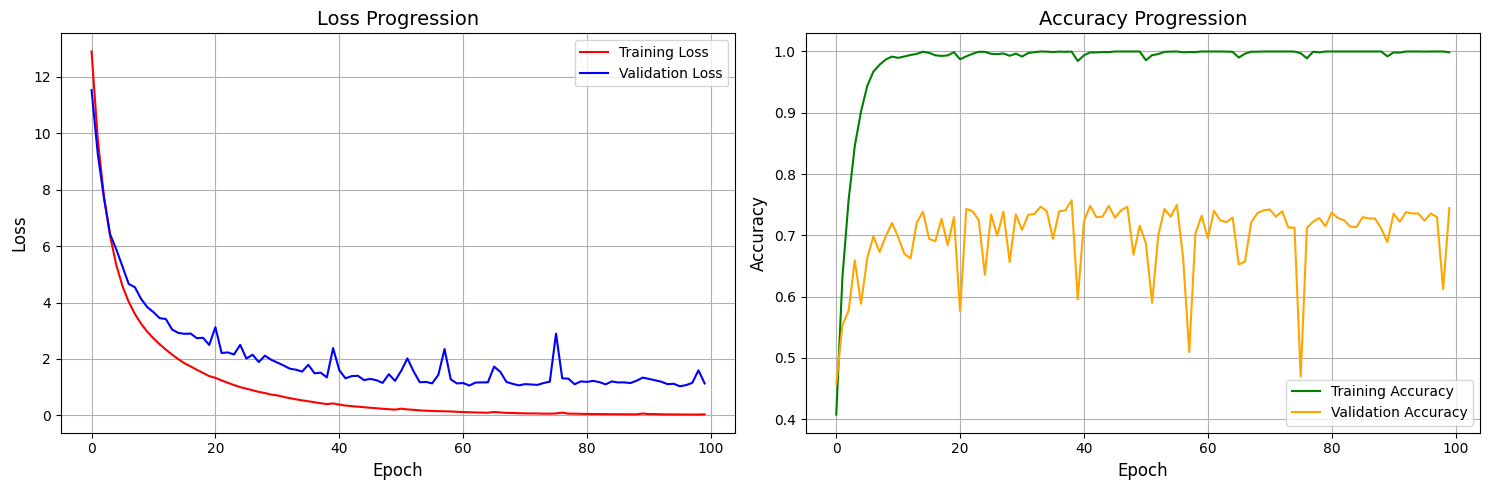

In [17]:
visualize(history, 'all_features')

In [18]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['all_features'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['all_features'] = model.evaluate(validation_features, val_y)[-1]

165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9997 - loss: 0.0285 - weighted_accuracy: 0.9997
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7398 - loss: 1.1541 - weighted_accuracy: 0.7398


In [19]:
val_scores['all_features'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.80      0.78      0.79       114
           1       0.76      0.62      0.68       141
           2       0.89      0.92      0.91       271
           3       0.62      0.80      0.70        90
           4       1.00      0.33      0.50        18
           5       0.20      0.07      0.10        15
           6       0.45      0.65      0.54        23
           7       1.00      1.00      1.00        44
           8       0.40      0.74      0.52        50
           9       0.90      0.90      0.90        49
          10       0.73      0.50      0.59        48
          11       0.72      0.50      0.59        46
          12       0.82      0.94      0.88        54
          13       0.67      0.77      0.72        48
          14       0.63      0.50      0.56        38
          15       0.59      0.55      0.57       117
          16       0.96      0.93      0.94   

### Mel Spectrogram and Chroma

In [20]:
# Train features
target_size = 128
chroma_tiled = tile_and_crop(train_features['chroma'], target_size)

training_features = np.stack((train_features['melspectrogram'],  chroma_tiled), axis=-1)
print(training_features.shape)

(5278, 128, 259, 2)


In [21]:
# Validation Features
target_size = 128
chroma_tiled = tile_and_crop(val_features['chroma'], target_size)

validation_features = np.stack((val_features['melspectrogram'],  chroma_tiled), axis=-1)
print(validation_features.shape)

(1350, 128, 259, 2)


In [22]:
model = build_model(training_features)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1
)

Model: "Birds"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 128, 259, 2)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv2D)                      │ (None, 128, 259, 64)        │           3,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling2D)                │ (None, 64, 129, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, 64, 129, 32)         │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_2 (MaxPooling2D)                │ (None, 32, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_3 (Conv2D)                      │ (None, 32, 64, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_3 (MaxPooling2D)                │ (None, 16, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 512)                 │       8,389,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_2 (Dense)                         │ (None, 20)                  │          10,260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,479,636 (32.35 MB)

 Trainable params: 8,479,572 (32.35 MB)

 Non-trainable params: 64 (256.00 B)

None
Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 17s 80ms/step - accuracy: 0.3976 - loss: 12.9624 - weighted_accuracy: 0.3976 - val_accuracy: 0.3481 - val_loss: 11.6163 - val_weighted_accuracy: 0.3481
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.7472 - loss: 9.3054 - weighted_accuracy: 0.7472 - val_accuracy: 0.6081 - val_loss: 9.1213 - val_weighted_accuracy: 0.6081
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.8499 - loss: 7.3130 - weighted_accuracy: 0.8499 - val_accuracy: 0.6326 - val_loss: 7.1430 - val_weighted_accuracy: 0.6326
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.9001 - loss: 5.9303 - weighted_accuracy: 0.9001 - val_accuracy: 0.6748 - val_loss: 5.9074 - val_weighted_accuracy: 0.6748
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9311 - loss: 4.9071 - weighted_accuracy: 0.9311 - val_accuracy: 0.7230 - val_loss: 4.9670 - val_weighted_accuracy: 0.7230
Epoch 6/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 8

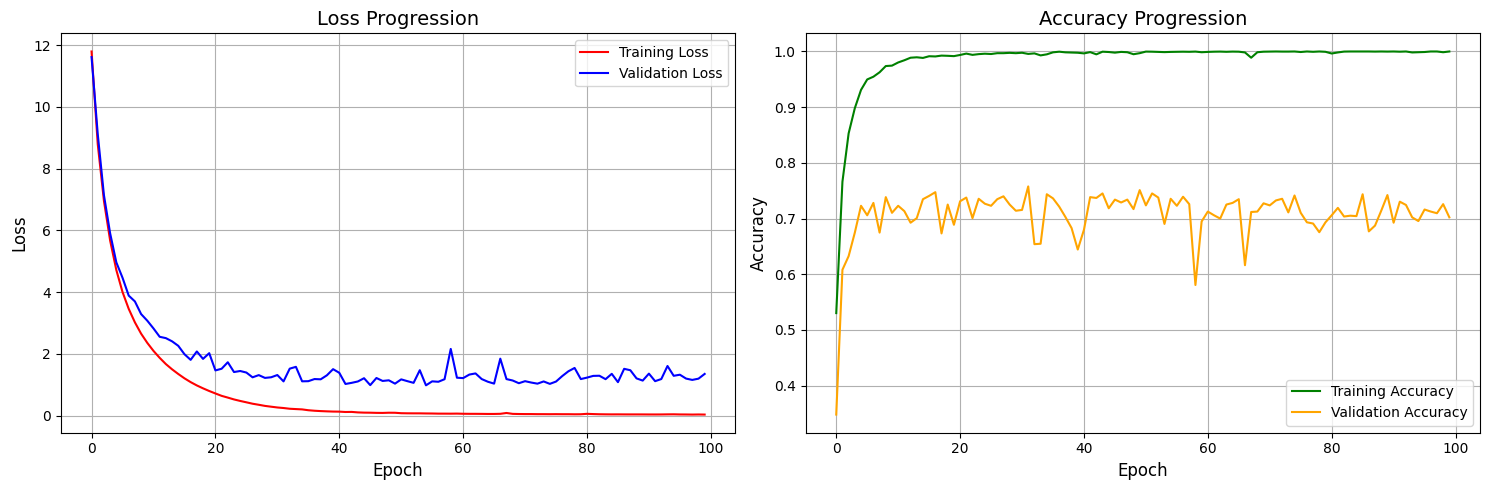

In [23]:
visualize(history, 'melspectrogram_chroma')

In [24]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram_chroma'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram_chroma'] = model.evaluate(validation_features, val_y)[-1]

165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9999 - loss: 0.0382 - weighted_accuracy: 0.9999
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7016 - loss: 1.3493 - weighted_accuracy: 0.7016


In [25]:
val_scores['melspectrogram_chroma'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       114
           1       0.42      0.62      0.50       141
           2       0.85      0.51      0.64       271
           3       0.83      1.00      0.90        90
           4       1.00      0.39      0.56        18
           5       0.67      0.13      0.22        15
           6       0.30      0.52      0.38        23
           7       1.00      1.00      1.00        44
           8       0.74      0.62      0.67        50
           9       0.63      0.94      0.75        49
          10       0.85      0.85      0.85        48
          11       0.62      0.52      0.56        46
          12       0.66      0.72      0.69        54
          13       0.63      0.75      0.69        48
          14       0.60      0.84      0.70        38
          15       0.70      0.51      0.59       117
          16       1.00      0.96      0.98   

### With Mel Spectrogram, MFCCs and Chroma

In [26]:
# Train features
target_size = 128
mfcc_tiled = tile_and_crop(train_features['mfcc'], target_size)
chroma_tiled = tile_and_crop(train_features['chroma'], target_size)

training_features = np.stack((train_features['melspectrogram'], mfcc_tiled, chroma_tiled), axis=-1)
print(training_features.shape)

(5278, 128, 259, 3)


In [27]:
# Validation Features
target_size = 128
mfcc_tiled = tile_and_crop(val_features['mfcc'], target_size)
chroma_tiled = tile_and_crop(val_features['chroma'], target_size)

validation_features = np.stack((val_features['melspectrogram'], mfcc_tiled, chroma_tiled), axis=-1)
print(validation_features.shape)

(1350, 128, 259, 3)


In [28]:
model = build_model(training_features)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1
)

Model: "Birds"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 128, 259, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv2D)                      │ (None, 128, 259, 64)        │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling2D)                │ (None, 64, 129, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, 64, 129, 32)         │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_2 (MaxPooling2D)                │ (None, 32, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_3 (Conv2D)                      │ (None, 32, 64, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_3 (MaxPooling2D)                │ (None, 16, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 512)                 │       8,389,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_2 (Dense)                         │ (None, 20)                  │          10,260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,481,236 (32.35 MB)

 Trainable params: 8,481,172 (32.35 MB)

 Non-trainable params: 64 (256.00 B)

None
Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - accuracy: 0.3804 - loss: 13.3811 - weighted_accuracy: 0.3804 - val_accuracy: 0.3237 - val_loss: 12.0667 - val_weighted_accuracy: 0.3237
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.7108 - loss: 9.8616 - weighted_accuracy: 0.7108 - val_accuracy: 0.6593 - val_loss: 9.6275 - val_weighted_accuracy: 0.6593
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.8123 - loss: 7.8451 - weighted_accuracy: 0.8123 - val_accuracy: 0.6793 - val_loss: 7.4976 - val_weighted_accuracy: 0.6793
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.8656 - loss: 6.4342 - weighted_accuracy: 0.8656 - val_accuracy: 0.7185 - val_loss: 6.2055 - val_weighted_accuracy: 0.7185
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.9170 - loss: 5.3625 - weighted_accuracy: 0.9170 - val_accuracy: 0.6919 - val_loss: 5.4768 - val_weighted_accuracy: 0.6919
Epoch 6/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 8

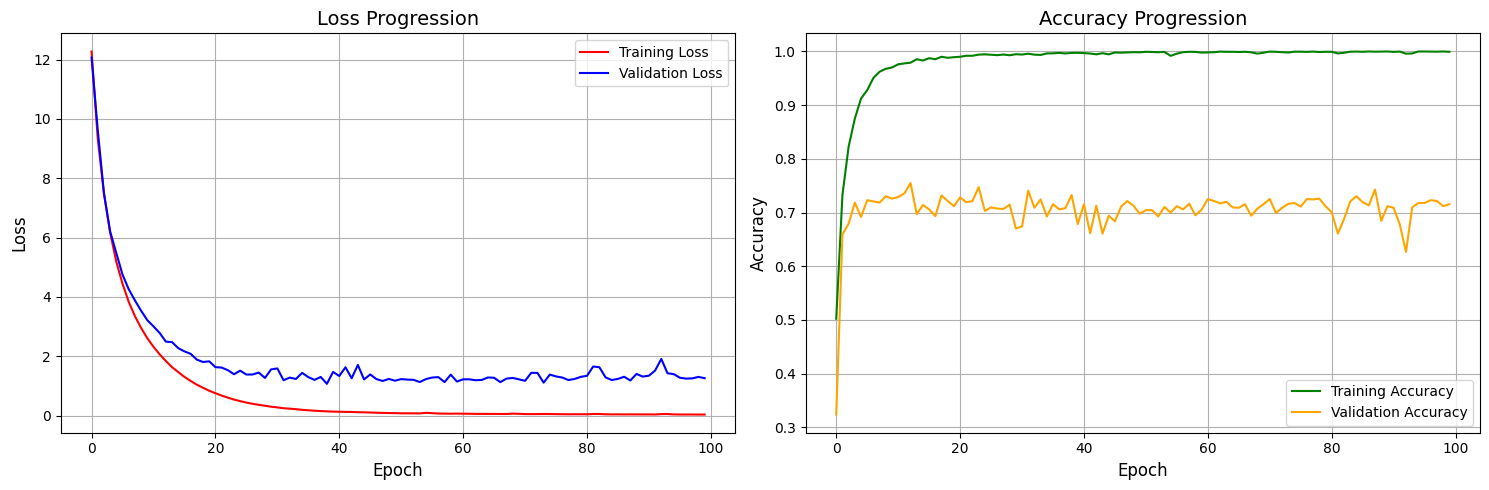

In [29]:
visualize(history, 'melspectrogram_chroma_mfcc')

In [30]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram_chroma_mfcc'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram_chroma_mfcc'] = model.evaluate(validation_features, val_y)[-1]

165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 1.0000 - loss: 0.0378 - weighted_accuracy: 1.0000
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7220 - loss: 1.2425 - weighted_accuracy: 0.7220


In [31]:
val_scores['melspectrogram_chroma_mfcc'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.92      0.89      0.90       114
           1       0.44      0.51      0.47       141
           2       0.73      0.56      0.63       271
           3       0.83      1.00      0.91        90
           4       0.92      0.67      0.77        18
           5       0.75      0.20      0.32        15
           6       0.25      0.61      0.35        23
           7       1.00      0.98      0.99        44
           8       0.79      0.52      0.63        50
           9       0.82      0.94      0.88        49
          10       0.90      0.79      0.84        48
          11       0.60      0.76      0.67        46
          12       0.83      0.74      0.78        54
          13       0.66      0.60      0.63        48
          14       0.52      0.76      0.62        38
          15       0.61      0.63      0.62       117
          16       1.00      0.91      0.95   

### With Mel Spectrogram and MFCCs

In [32]:
# Train features
target_size = 128
mfcc_tiled = tile_and_crop(train_features['mfcc'], target_size)

training_features = np.stack((train_features['melspectrogram'], mfcc_tiled), axis=-1)
print(training_features.shape)

(5278, 128, 259, 1)


In [33]:
# Validation Features
target_size = 128
mfcc_tiled = tile_and_crop(val_features['mfcc'], target_size)

validation_features = np.stack((val_features['melspectrogram'], mfcc_tiled), axis=-1)
print(validation_features.shape)

(1350, 128, 259, 1)


In [34]:
model = build_model(training_features)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1
)

Model: "Birds"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 128, 259, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv2D)                      │ (None, 128, 259, 64)        │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling2D)                │ (None, 64, 129, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, 64, 129, 32)         │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_2 (MaxPooling2D)                │ (None, 32, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_3 (Conv2D)                      │ (None, 32, 64, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_3 (MaxPooling2D)                │ (None, 16, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 512)                 │       8,389,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_2 (Dense)                         │ (None, 20)                  │          10,260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,478,036 (32.34 MB)

 Trainable params: 8,477,972 (32.34 MB)

 Non-trainable params: 64 (256.00 B)

None
Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 16s 72ms/step - accuracy: 0.3639 - loss: 12.7424 - weighted_accuracy: 0.3639 - val_accuracy: 0.5281 - val_loss: 11.1516 - val_weighted_accuracy: 0.5281
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.7198 - loss: 8.8361 - weighted_accuracy: 0.7198 - val_accuracy: 0.5815 - val_loss: 8.5860 - val_weighted_accuracy: 0.5815
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.8363 - loss: 6.5790 - weighted_accuracy: 0.8363 - val_accuracy: 0.6267 - val_loss: 6.3605 - val_weighted_accuracy: 0.6267
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.8878 - loss: 5.0600 - weighted_accuracy: 0.8878 - val_accuracy: 0.7296 - val_loss: 4.8071 - val_weighted_accuracy: 0.7296
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9252 - loss: 3.9965 - weighted_accuracy: 0.9252 - val_accuracy: 0.6607 - val_loss: 4.1976 - val_weighted_accuracy: 0.6607
Epoch 6/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 7

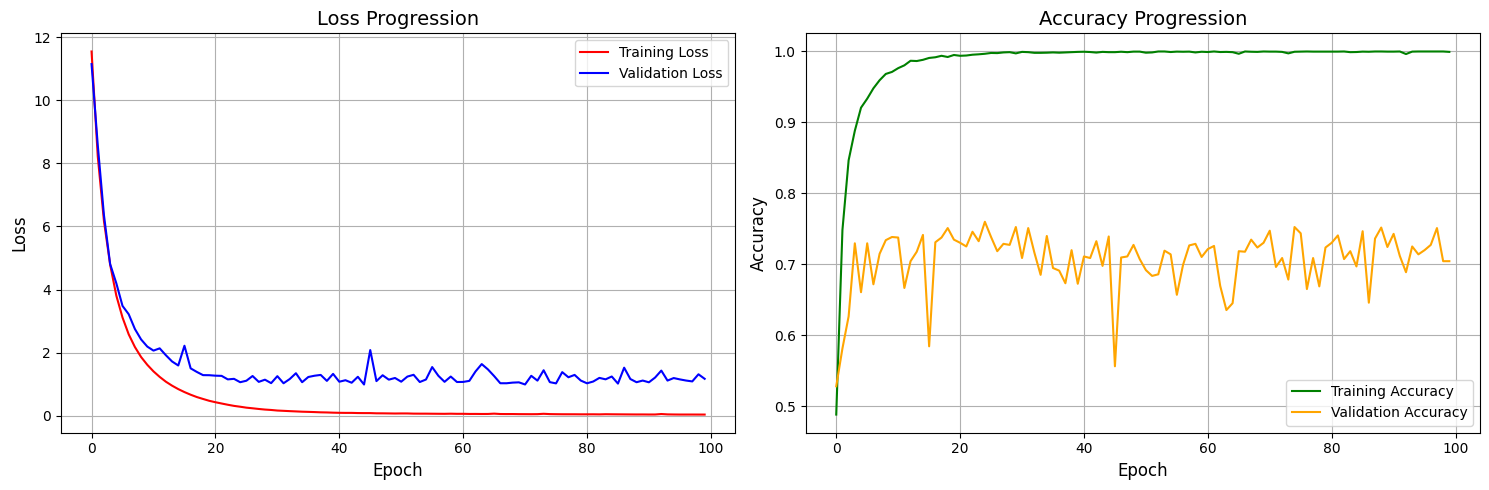

In [35]:
visualize(history, 'mfcc_melspectrogram')

In [36]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['mfcc_melspectrogram'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['mfcc_melspectrogram'] = model.evaluate(validation_features, val_y)[-1]

165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 1.0000 - loss: 0.0327 - weighted_accuracy: 1.0000
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6976 - loss: 1.2283 - weighted_accuracy: 0.6976


In [37]:
val_scores['mfcc_melspectrogram'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.71      0.84      0.77       114
           1       0.46      0.60      0.52       141
           2       0.84      0.55      0.66       271
           3       0.93      1.00      0.96        90
           4       1.00      0.22      0.36        18
           5       0.67      0.13      0.22        15
           6       0.31      0.65      0.42        23
           7       0.98      1.00      0.99        44
           8       0.79      0.54      0.64        50
           9       0.81      0.94      0.87        49
          10       0.86      0.79      0.83        48
          11       0.58      0.54      0.56        46
          12       0.80      0.74      0.77        54
          13       0.68      0.88      0.76        48
          14       0.51      0.79      0.62        38
          15       0.55      0.55      0.55       117
          16       0.94      0.91      0.93   

### With Mel Spectrogram

In [43]:
# Train features
target_size = 128

training_features = np.expand_dims(train_features['melspectrogram'], axis=-1)
print(training_features.shape)

(5278, 128, 259, 1)


In [44]:
# Validation Features
target_size = 128
validation_features = np.expand_dims(val_features['melspectrogram'], axis=-1)
print(validation_features.shape)

(1350, 128, 259, 1)


In [45]:
model = build_model(training_features)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1
)

Model: "Birds"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 128, 259, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv2D)                      │ (None, 128, 259, 64)        │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling2D)                │ (None, 64, 129, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, 64, 129, 32)         │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_2 (MaxPooling2D)                │ (None, 32, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_3 (Conv2D)                      │ (None, 32, 64, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_3 (MaxPooling2D)                │ (None, 16, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 512)                 │       8,389,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_2 (Dense)                         │ (None, 20)                  │          10,260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,478,036 (32.34 MB)

 Trainable params: 8,477,972 (32.34 MB)

 Non-trainable params: 64 (256.00 B)

None
Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - accuracy: 0.3542 - loss: 12.7267 - weighted_accuracy: 0.3542 - val_accuracy: 0.2837 - val_loss: 11.0145 - val_weighted_accuracy: 0.2837
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.7362 - loss: 8.6327 - weighted_accuracy: 0.7362 - val_accuracy: 0.4874 - val_loss: 8.4046 - val_weighted_accuracy: 0.4874
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8406 - loss: 6.3570 - weighted_accuracy: 0.8406 - val_accuracy: 0.7459 - val_loss: 5.9497 - val_weighted_accuracy: 0.7459
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9068 - loss: 4.8461 - weighted_accuracy: 0.9068 - val_accuracy: 0.6385 - val_loss: 4.8415 - val_weighted_accuracy: 0.6385
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9243 - loss: 3.8274 - weighted_accuracy: 0.9243 - val_accuracy: 0.6859 - val_loss: 4.0339 - val_weighted_accuracy: 0.6859
Epoch 6/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 7

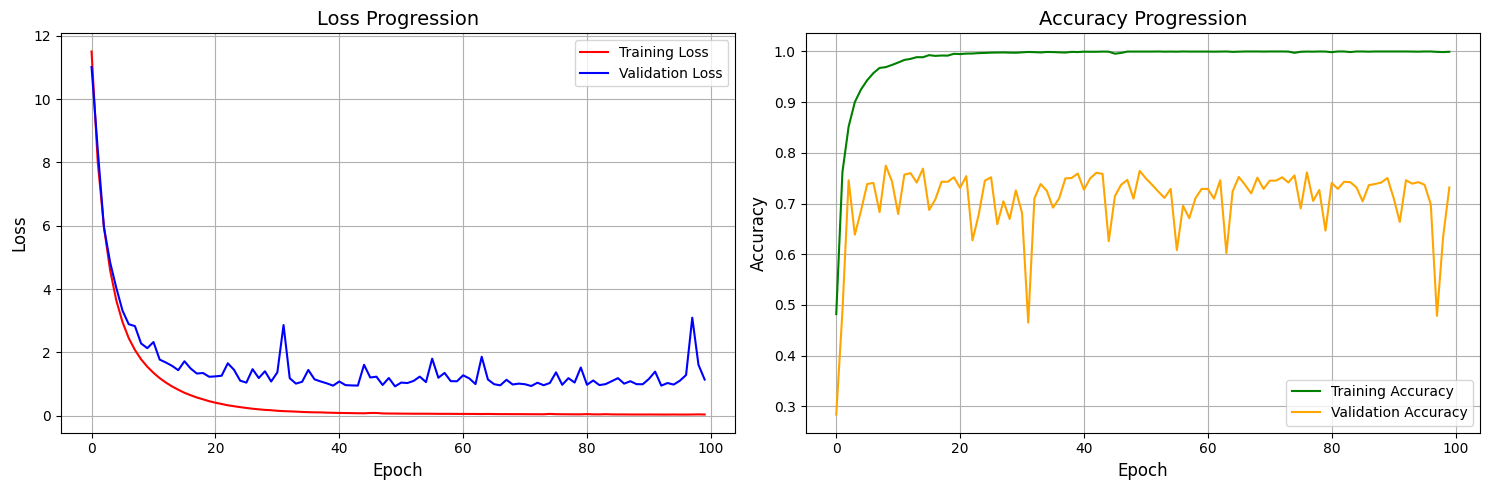

In [46]:
visualize(history, 'melspectrogram')

In [47]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram'] = model.evaluate(validation_features, val_y)[-1]

165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9993 - loss: 0.0369 - weighted_accuracy: 0.9993
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7119 - loss: 1.2563 - weighted_accuracy: 0.7119


In [48]:
val_scores['melspectrogram'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.83      0.77      0.80       114
           1       0.50      0.54      0.52       141
           2       0.72      0.77      0.75       271
           3       0.93      1.00      0.96        90
           4       1.00      0.39      0.56        18
           5       0.50      0.13      0.21        15
           6       0.50      0.48      0.49        23
           7       0.92      1.00      0.96        44
           8       0.71      0.70      0.71        50
           9       0.67      0.94      0.78        49
          10       0.90      0.73      0.80        48
          11       0.85      0.37      0.52        46
          12       0.70      0.78      0.74        54
          13       0.56      0.92      0.69        48
          14       0.51      0.79      0.62        38
          15       0.72      0.41      0.52       117
          16       0.90      0.98      0.94   

## Review all the results

In [49]:
train_results_df = pd.DataFrame(list(train_results.items()), columns=['Features', 'Train_Accuracy']).round(3)
val_results_df = pd.DataFrame(list(val_results.items()), columns=['Features', 'Val_Accuracy']).round(3)

result_df = train_results_df.merge(val_results_df, on='Features')
result_df = result_df.sort_values('Features')
result_df

,Features,Train_Accuracy,Val_Accuracy
0,all_features,1.0,0.744
4,melspectrogram,1.0,0.732
1,melspectrogram_chroma,1.0,0.702
2,melspectrogram_chroma_mfcc,1.0,0.716
3,mfcc_melspectrogram,1.0,0.704


In [50]:
val_scores_df = pd.DataFrame([(key, value['f1'], value['auc']) for key, value in val_scores.items()],
                             columns=['Features', 'F1_Score', 'AUC_Score']).round(3)

val_scores_df = val_scores_df.sort_values('Features')
print(val_scores_df)

                     Features  F1_Score  AUC_Score
0                all_features     0.741      0.975
4              melspectrogram     0.724      0.970
1       melspectrogram_chroma     0.704      0.968
2  melspectrogram_chroma_mfcc     0.719      0.964
3         mfcc_melspectrogram     0.704      0.970
